In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lenstronomy.GalKin.analytic_kinematics import AnalyticKinematics
from lenstronomy.GalKin.numeric_kinematics import NumericKinematics
from lenstronomy.Analysis.kinematics_api import KinematicsAPI
from astropy.cosmology import FlatLambdaCDM

In [2]:
r_eff = 1.85
theta_e = 1.63
gamma = 2
z_d = 0.295
z_s = 0.657

# analytic = get_v_rms(theta_e, gamma, r_eff, direct_convolve=False)
# numeric = get_v_rms(theta_e, gamma, r_eff, analytic=False)

In [3]:
from lenstronomy.GalKin.numeric_kinematics import NumericKinematics
from lenstronomy.GalKin.analytic_kinematics import AnalyticKinematics
from astropy.cosmology import FlatLambdaCDM

z_d = 0.295
z_s = 0.657

kwargs_model = {
                'mass_profile_list': ['PEMD'],
                'light_profile_list': ['HERNQUIST'],
                'anisotropy_model': 'OM',
                #'lens_redshift_list': [z_d],
                }

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_d = cosmo.angular_diameter_distance(z_d).value
D_s = cosmo.angular_diameter_distance(z_s).value
D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value

kwargs_cosmo = {'d_d': D_d, 'd_s': D_s, 'd_ds': D_ds}

numeric_kin = NumericKinematics(kwargs_model, kwargs_cosmo,
                                interpol_grid_num=1000, max_integrate=100, min_integrate=1e-3)
analytic_kin = AnalyticKinematics(kwargs_cosmo, 
                                  interpol_grid_num=2000, max_integrate=100, min_integrate=1e-3)

numeric 1000 True 100 0.001
analytic 2000 True 100 0.001


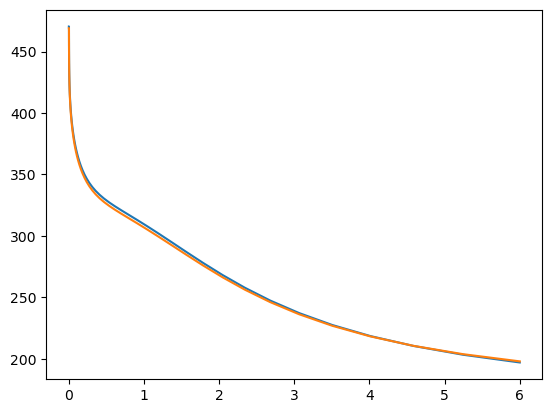

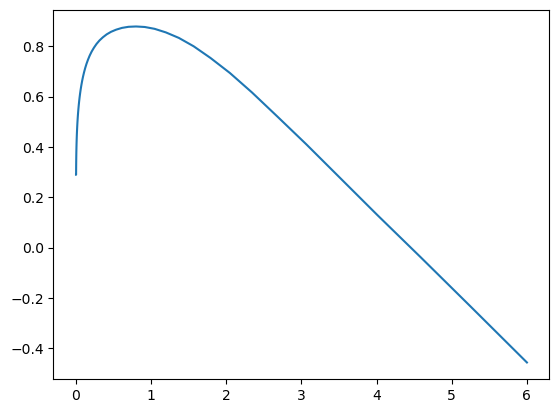

In [4]:
R = np.logspace(-5, np.log10(6), 100)
r_eff = 1.85
theta_e = 1.63
gamma = 2
a_ani = 1

numeric_s2ir, numeric_ir = numeric_kin.I_R_sigma2_and_IR(R, 
                              [{'theta_E': theta_e, 'gamma': gamma, 'center_x': 0., 'center_y': 0.}], 
                              [{'Rs': r_eff * 0.551, 'amp': 1., 'center_x': 0., 'center_y': 0.}],
                              {'r_ani': a_ani * r_eff})

numeric_vel_dis = np.sqrt(numeric_s2ir/numeric_ir)/1e3


analytic_s2ir = np.zeros_like(R)
analytic_ir = np.zeros_like(R)

for i, r in enumerate(R):
    analytic_s2ir[i], analytic_ir[i] = analytic_kin.I_R_sigma2_and_IR(r, 
                              {'theta_E': theta_e, 'gamma': gamma, 'center_x': 0., 'center_y': 0.}, 
                              {'Rs': r_eff * 0.551, 'amp': 1., 'center_x': 0., 'center_y': 0.},
                              {'r_ani': a_ani * r_eff})

analytic_vel_dis = np.sqrt(analytic_s2ir/analytic_ir)/1e3

plt.plot(R, numeric_vel_dis)
plt.plot(R, analytic_vel_dis)
#plt.xscale('log')
plt.show()

plt.plot(R, ((numeric_vel_dis - analytic_vel_dis) / analytic_vel_dis) * 100)
plt.show()

# plt.plot(R, (numeric_ir - analytic_ir)/analytic_ir * 100)
# plt.show()
# plt.plot(R, (numeric_s2ir - analytic_s2ir)/analytic_s2ir * 100)
# plt.show()
# plt.plot(R, s2ir)

In [5]:
def get_v_rms(theta_e, gamma, r_eff, a_ani=1,
                      z_d=0.295, z_s = 0.657, analytic=False
                      ):
    """
    Compute v_rms for power-law mass and Hernquist light using Galkin's numerical
    approach.
    :param hernquist_mass: if mass in M_sun provided, uses Hernquist mass profile. For debugging purpose.
    :param do_mge: True will use lenstronomy's own MGE implementation
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(0.5, 2.).value

    kwargs_cosmo = {'d_d': D_d, 'd_s': D_s, 'd_ds': D_ds}
    
    xs, ys = np.meshgrid(np.linspace(-1, 1, 20),
                         np.linspace(-1, 1, 20)
                        )
    
    kwargs_aperture = {'aperture_type': 'IFU_grid',
                       'x_grid': xs,
                       'y_grid': ys,
                       }
    
    kwargs_seeing = {'psf_type': 'GAUSSIAN',
                     'fwhm': 0.7,
                     }
    
    kwargs_galkin_numerics = {#'sampling_number': 1000,
                              'interpol_grid_num': 2000,
                              'log_integration': True,
                              'max_integrate': 100,
                              'min_integrate': 0.001,
    }
    

    kwargs_model = {
                'lens_model_list': ['PEMD'],
                'lens_light_model_list': ['HERNQUIST'],
            }

    
    kinematics_api = KinematicsAPI(z_lens=z_d, z_source=z_s,
                                   kwargs_model=kwargs_model,
                                   kwargs_aperture=kwargs_aperture,
                                   kwargs_seeing=kwargs_seeing,
                                   anisotropy_model='OM',
                                   cosmo=cosmo,
                                   multi_observations=False,
                                   #kwargs_numerics_galkin=kwargs_galkin_numerics,
                                   analytic_kinematics=analytic,
                                   Hernquist_approx=False,
                                   MGE_light=False,
                                   MGE_mass=False, #self._cgd,
                                   kwargs_mge_light=None,
                                   kwargs_mge_mass=None,
                                   sampling_number=1000,
                                   num_kin_sampling=2000,
                                   num_psf_sampling=500,
                                   )
    
    
    kwargs_mass = [{
        'theta_E': theta_e, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 
        'e1': 0, 'e2': 0
    }]
    
    kwargs_light = [{
            'Rs': 0.551 * r_eff, 'amp': 1., 'center_x': 0, 'center_y': 0
        }]
    
    kwargs_anisotropy = {
        'r_ani': a_ani * r_eff
    }
        
    
    vel_dis, ir = kinematics_api.velocity_dispersion_map(
                    kwargs_mass,
                    kwargs_light,
                    kwargs_anisotropy,
                    r_eff=r_eff,
                    theta_E=theta_e,
                    gamma=gamma,
                    kappa_ext=0,
                    direct_convolve=True,
                    supersampling_factor=5,
                    voronoi_bins=None,
                    get_IR_map=True
                )
    
    return vel_dis, ir

In [6]:
%%time

analytic, analytic_ir = get_v_rms(theta_e, gamma, r_eff, analytic=True)

analytic 2000 True 100 0.0001
{'r_eff': 1.85, 'center_x': 0, 'center_y': 0}
CPU times: user 3.68 s, sys: 171 ms, total: 3.85 s
Wall time: 3.49 s


In [7]:
%%time

numeric, numeric_ir = get_v_rms(theta_e, gamma, r_eff, analytic=False)

numeric 1000 True 100 0.0001
[{'Rs': 1.0193500000000002, 'amp': 1.0, 'center_x': 0, 'center_y': 0}]
CPU times: user 1.51 s, sys: 7.72 ms, total: 1.51 s
Wall time: 1.51 s


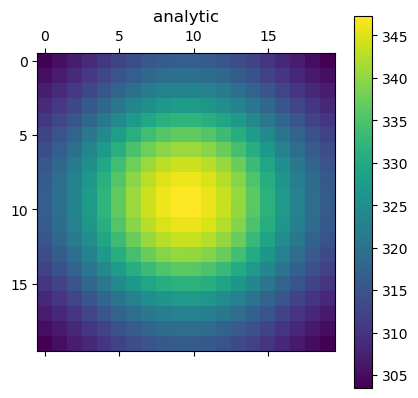

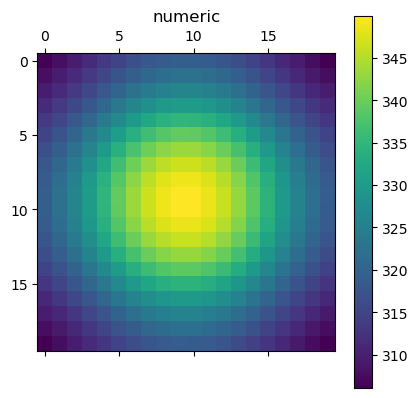

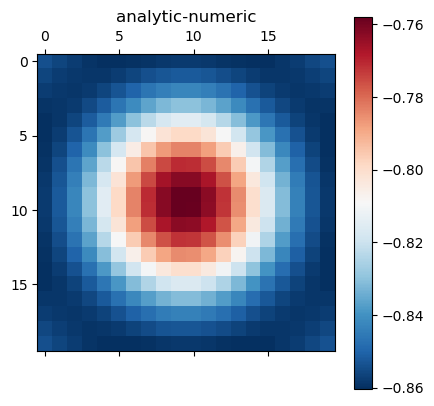

In [8]:
analytic_ir /= np.min(analytic_ir)
numeric_ir /= np.min(numeric_ir)

im = plt.matshow(analytic)
plt.colorbar(im)
plt.title('analytic')
plt.show()

im = plt.matshow(numeric)
plt.colorbar(im)
plt.title('numeric')
plt.show()

im = plt.matshow((analytic - numeric)/numeric*100, cmap='RdBu_r')
plt.colorbar(im)
plt.title('analytic-numeric')
plt.show()